# part0: imports

In [5]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(params)
    reload(defs)

finally:
    os.chdir(nbPath)

if "__file__" not in dir():

    %run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names


# Decoding

Decode the arm velocity from M1 activity.

## idea

train the decoder on monkey1 and decode the behaviour of monkey2

>**correction**: the idea is to decode kinematics from the aligned dynamics of 2 monkeys.

# Read data

In [6]:
full_list = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list.append((animal,sessionList))
full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

# load the DFs
warnings.filterwarnings("ignore")
allDFs = []
for animal, session in full_list:
    path = root/animal/session
    allDFs.append(defs.prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")

In [7]:
# pairIndexList = list[ tuple[train1, list[test]]]
pairIndexList = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndexList.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if animal1 != animal2: continue
        if session1 == session2: continue
        pairIndexList[-1][1].append(j)

# Within animal decoding across sessions

select sessions of the same animal $A$ and $B$ to compute the the canonical axes, and then decode kinematics. One decoder per pair of sessions, similar to the NN paper.

decoder performance cross-validated on the second day in each pair

cross-validating

**The method below should not be used!! It is just for confirmiation of the next step**

In [12]:
if "__file__" not in dir():

    warnings.filterwarnings("ignore")
    reg_scores = []
    for id1, testList in pairIndexList:
        for testId in testList:
            AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)

            # adding history
            AllData = dt.add_history_to_data_array(AllData,MAX_HISTORY)

            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel2 = AllVel[1,...]
            # resizing
            _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel2 = AllVel2.reshape((-1,2))

    #         *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            Y_x,Y_y = AllVel2.T
            # train the decoder
            x_score = cross_val_score(LinearRegression(), X2, Y_x, cv=5, scoring = custom_r2_scorer)
            y_score = cross_val_score(LinearRegression(), X2, Y_y, cv= 5, scoring = custom_r2_scorer)
            reg_scores.append((id1,testId,(x_score.mean(),y_score.mean())))
    warnings.filterwarnings("default")
    pop_score = []
    for _,_,scores in reg_scores:
        pop_score.append(np.add(*scores)/2)
    pop_score = np.array(pop_score)

In [ ]:
if "__file__" not in dir():

    print(pop_score.size)
    _,ax = plt.subplots()
    ax.plot(pop_score,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs')
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_title('Velocity Decoding')

The above results are much lower than the NN paper. But the paper doesn't cross-validate, instead it trains on one day, tests on the other and reports the $R^2$ value

In [5]:
if "__file__" not in dir():

    warnings.filterwarnings("ignore")
    reg_scores = []
    for id1, testList in pairIndexList:
        for testId in testList:
            AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1],allDFs[testId]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)

            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            # controlling the size
            AllVel2 = AllVel2.reshape((-1,2))
            AllVel1 = AllVel1.reshape((-1,2))

            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            Y_train_x,Y_train_y = AllVel1.T
            # train the decoder
            reg_x = LinearRegression()
            reg_y = LinearRegression()
            reg_x.fit(U, Y_train_x)
            reg_y.fit(U, Y_train_y)
            # test the decoder
            Y_test_x,Y_test_y = AllVel2.T
            x_score = defs.custom_r2_func(Y_test_x,reg_x.predict(V))
            y_score = defs.custom_r2_func(Y_test_y,reg_y.predict(V))
            reg_scores.append((id1,testId,(x_score,y_score)))
    warnings.filterwarnings("default")

    pop_score2 = []
    for _,_,scores in reg_scores:
        pop_score2.append(np.mean(scores))
    pop_score2 = np.array(pop_score2)

In [ ]:
if "__file__" not in dir():

    _,ax = plt.subplots()
    ax.plot(pop_score2,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs')
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_title('Velocity Decoding --- same animal, across days')

# Within animal, within session

Same as *"within-day"* analysis of the NN paper

In [8]:
warnings.filterwarnings("ignore")
reg_scores = []

for i, df in enumerate(allDFs):
    AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)

    # adding history
    AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
   
    n_trials = int(AllData.shape[-3] /2)
    AllData1 = AllData[0,...][:,:n_trials, :,:]
    AllData2 = AllData[0,...][:,-n_trials:,:,:]
    AllVel1 = AllVel[0,...][:,:n_trials, :,:]
    AllVel2 = AllVel[0,...][:,-n_trials:,:,:]
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
    # resizing
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    # controlling the size
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    Y_train_x,Y_train_y = AllVel1.T
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    
    x_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_x,Y_test_x)),scoring=defs.custom_r2_scorer, cv=5).mean()
    y_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_y,Y_test_y)),scoring=defs.custom_r2_scorer, cv=5).mean()
    
    reg_scores.append((i,(x_score,y_score)))
warnings.filterwarnings("default")

pop_score_day = []
for _,scores in reg_scores:
    pop_score_day.append(np.mean(scores))
pop_score_day = np.array(pop_score_day)

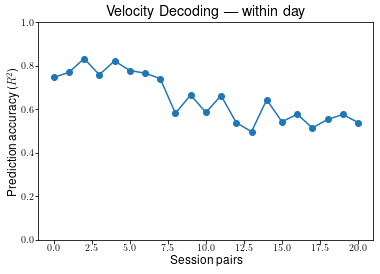

In [9]:
if "__file__" not in dir():

    _,ax = plt.subplots()
    ax.plot(pop_score_day,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs');
    ax.set_ylabel('Prediction accuracy ($R^2$)');
    ax.set_title('Velocity Decoding --- within day');

Now... Same as above, for different animals

# Across animal decoding

## With alignment 

In [10]:
pairIndex_across = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndex_across.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if j <= i: continue
        if animal1 == animal2: continue
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue
        pairIndex_across[-1][1].append(j)
pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

In [11]:
warnings.filterwarnings("ignore")
reg_scores_across = []
for id1, testId in pairIndex_across:
    AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1],allDFs[testId]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
    
    # adding history
    AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T
    
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
    reg_scores_across.append((id1,testId,(x_score,y_score)))
warnings.filterwarnings("default")

pop_score_across = []
for _,_,scores in reg_scores_across:
    pop_score_across.append(np.mean(scores))
pop_score_across = np.array(pop_score_across)

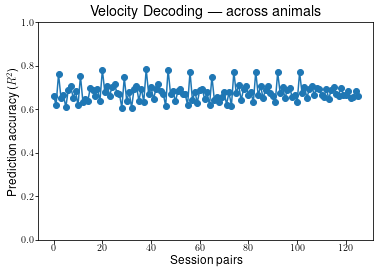

In [12]:
if "__file__" not in dir():

    _,ax = plt.subplots()
    ax.plot(pop_score_across,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs')
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_title('Velocity Decoding --- across animals')

## Without alignment

In [13]:
if "__file__" not in dir():

    warnings.filterwarnings("ignore")
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1],allDFs[testId]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,2))
        AllVel1 = AllVel1.reshape((-1,2))

        # train the decoder
    #     *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        Y_train_x,Y_train_y = AllVel1.T

        reg_x, reg_y = LinearRegression(), LinearRegression()
        reg_x.fit(X1, Y_train_x)
        reg_y.fit(X1, Y_train_y)
        # test the decoder
        Y_test_x,Y_test_y = AllVel2.T
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(X2))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(X2))
        reg_latent_scores.append((id1,testId,(x_score,y_score)))
    warnings.filterwarnings("default")

    pop_latent_score = []
    for _,_,scores in reg_latent_scores:
        pop_latent_score.append(np.mean(scores))
    pop_latent_score = np.array(pop_latent_score)

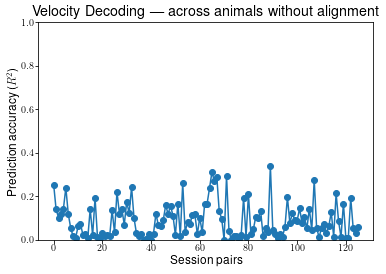

In [14]:
if "__file__" not in dir():

    _,ax = plt.subplots()
    ax.plot(pop_latent_score,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs')
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_title('Velocity Decoding --- across animals without alignment')

# Universal Decoder

In [15]:
if "__file__" not in dir():

    %run "_MCx-universal-decoding.ipynb"

# histograms

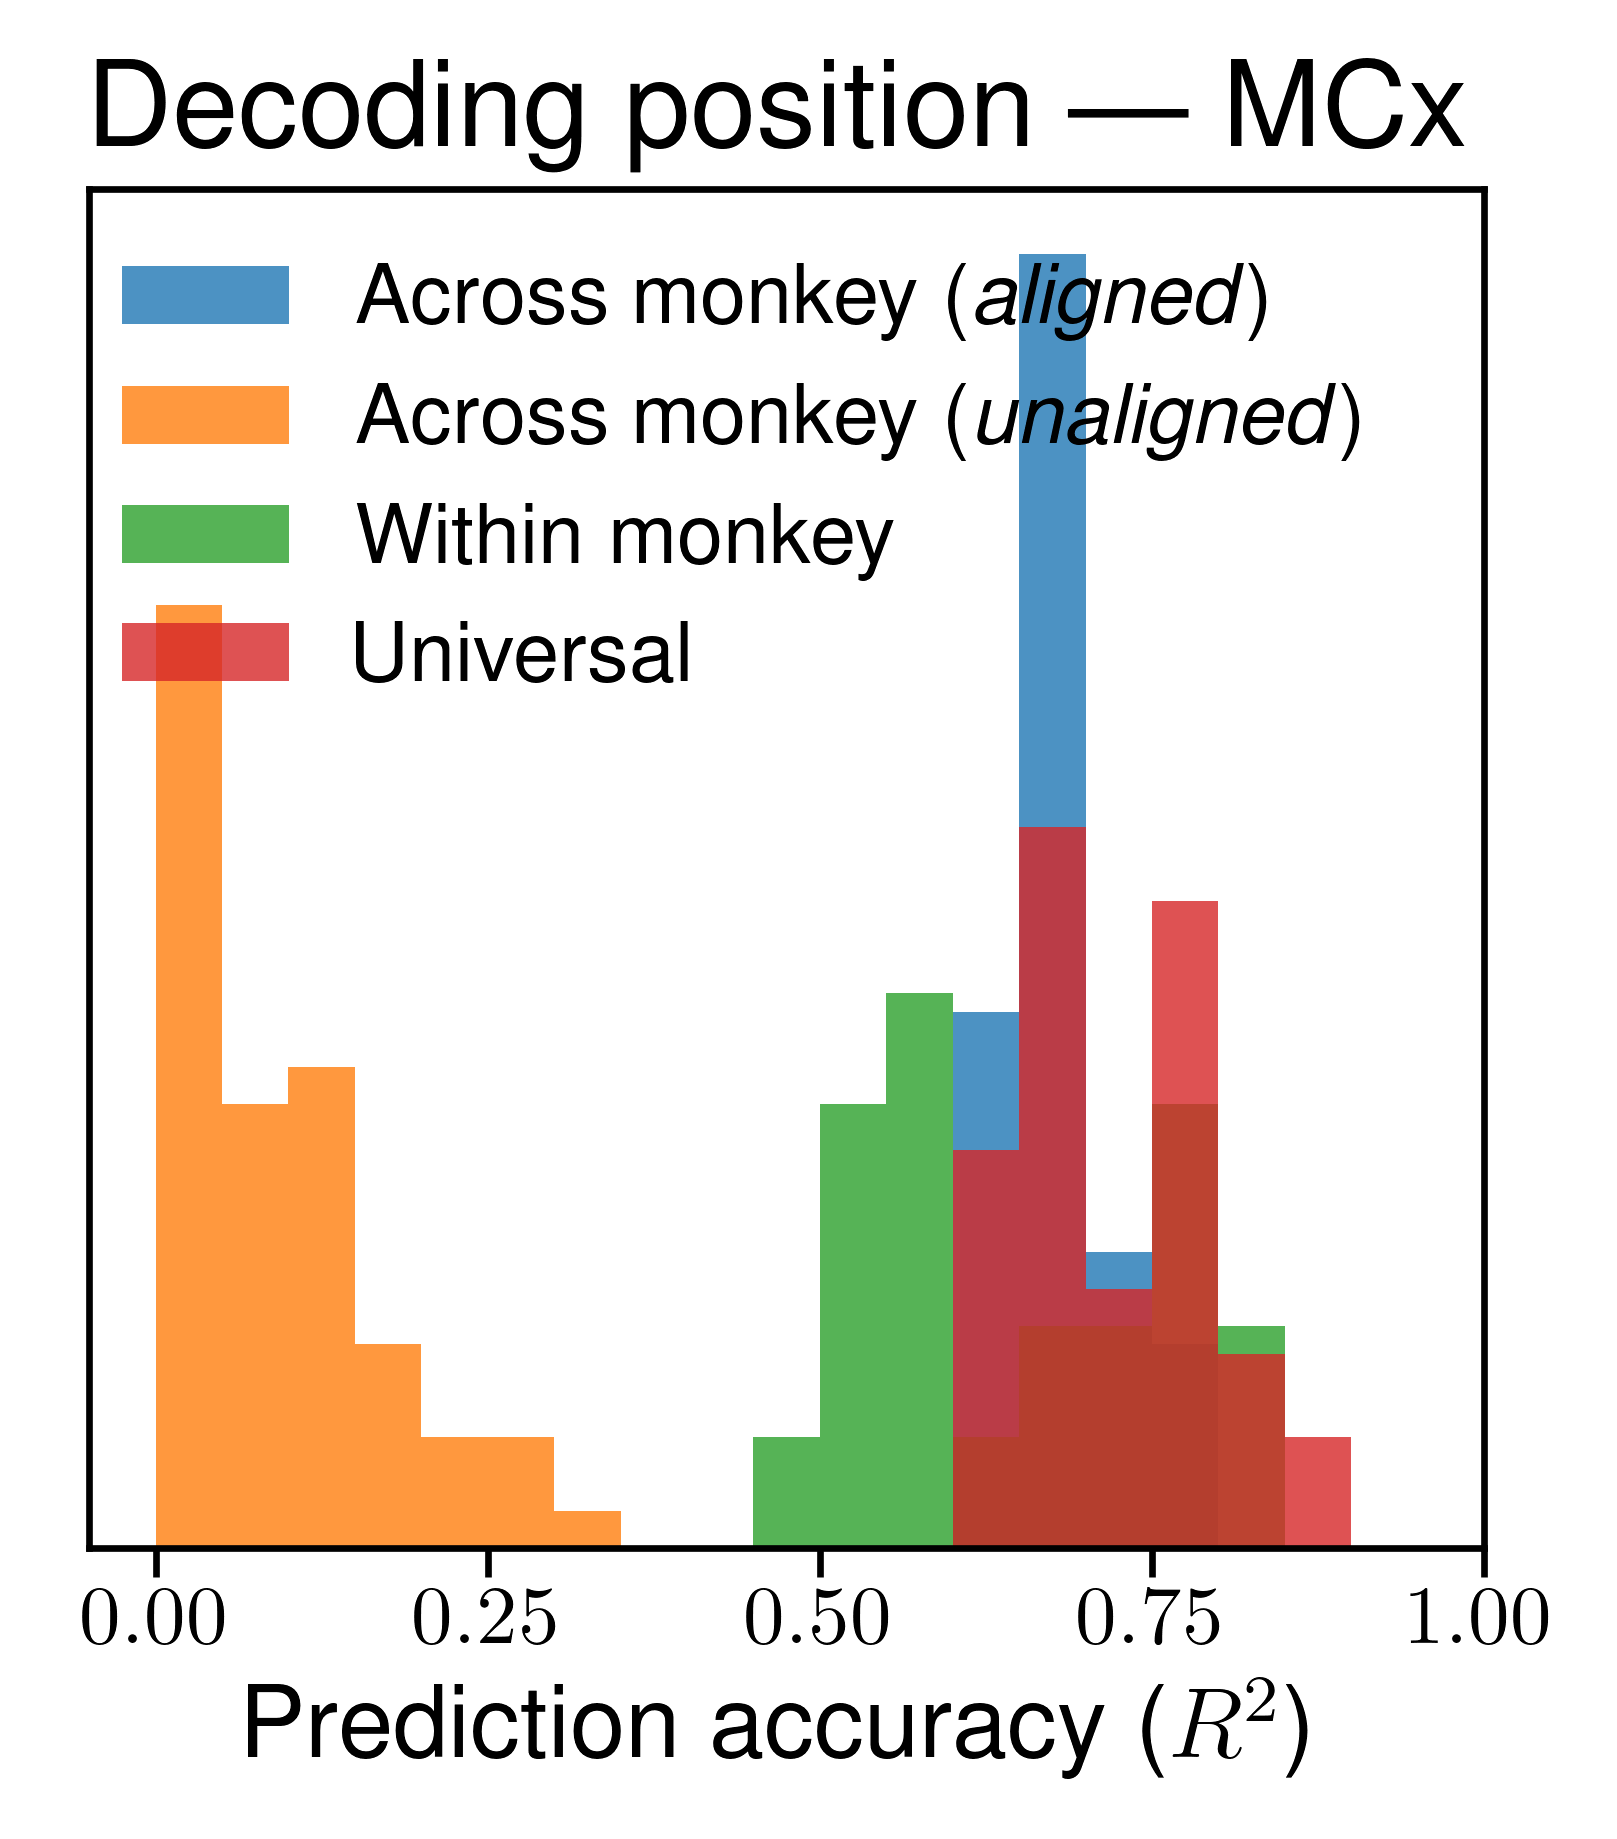

In [16]:
if "__file__" not in dir():

    fig,ax = plt.subplots(figsize=(3,3))

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across, bins=bins, density=True, label=r'Across monkey (\textit{aligned})', alpha=.8)
    ax.hist(pop_latent_score, bins=bins, density=True, label=r'Across monkey (\textit{unaligned})', alpha=.8)
    # ax.hist(pop_score2, bins=bins, density=True, label='aligned across days', alpha=.8)
    ax.hist(pop_score_day, bins=bins, density=True, label='Within monkey', alpha=.8)
    ax.hist(pop_score_uni, bins=bins, density=True, label='Universal', alpha=.8)

    ax.set_title('Decoding position --- MCx')
    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc=(0,.6))

    fig.savefig(params.figPath / 'monkey-MCx-decode.pdf', format='pdf', bbox_inches='tight')